<a href="https://colab.research.google.com/github/erdemsirel/data_science_case/blob/main/DataScienceCaseThalia_Master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

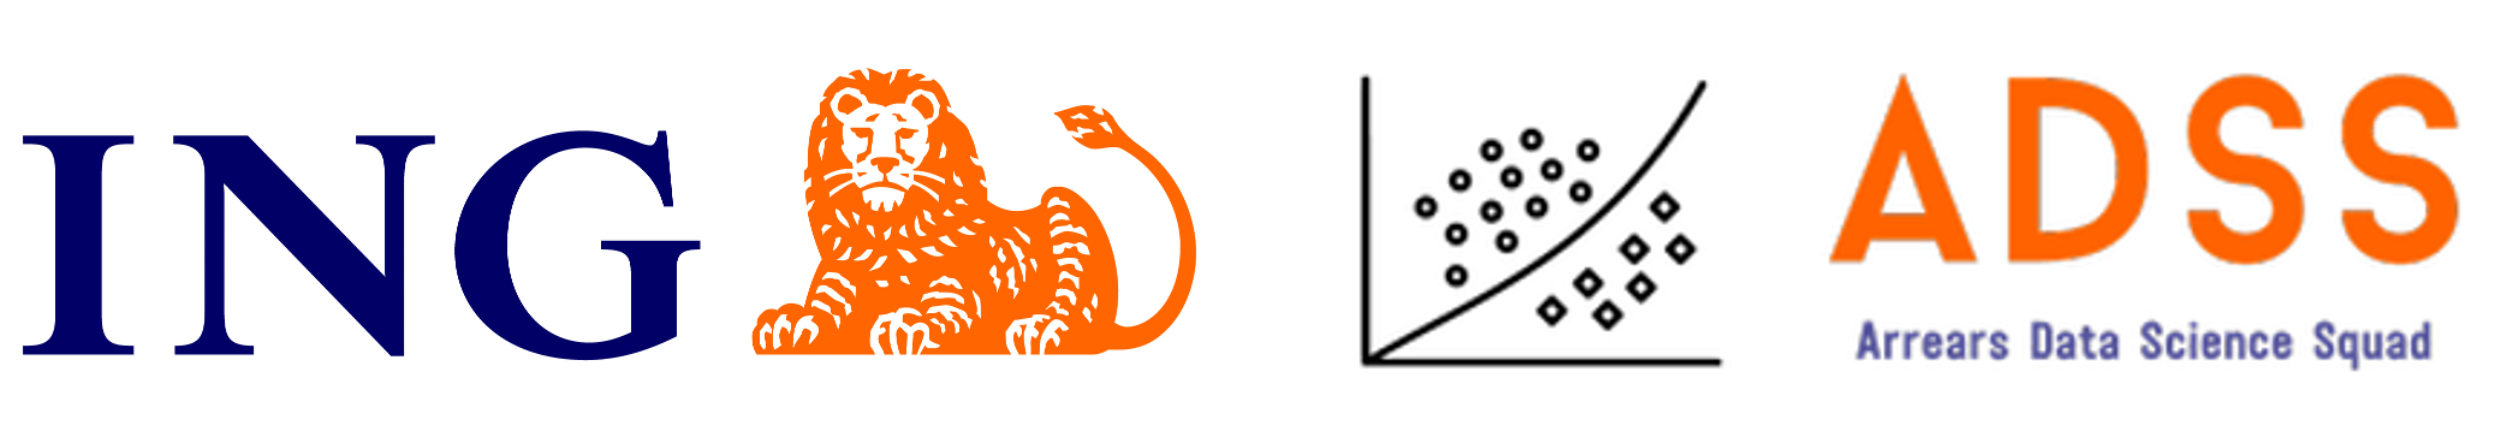

# Description

## Welcome to the case!  
**Are you up for a challenge where you will identify customers who experience financial difficulties via Machine Learning? Are you curious about how we do Data Science in ING?**  

In ING Collections, we are here to help customers when they experience financial difficulties. In this challenge, we will try to identify the risky loans and the customers with financial problems.
First, we will build a baseline machine learning model together, and you will have a chance to see our way of working and the basics of data science & machine learning.  
In the second part of the case, you will try to improve the baseline model by exploring some modeling techniques we use on a day-to-day basis.

## Aim
* We are trying to predict if a customer will be able to pay their debt within 30 days after the due date.
* Developing a model that can predict test data the best and (most importantly) help greatest number of customers with lowest cost possible.
* In the test data there are 8148 customers, 1812 of which are having financial issues. We need to identify those customers and help them!
* You can only help 2000 of them with the existing capacity. 
* If you predict more than 2000 positive cases, each 75 predicted positive case will cost you €13000.
* Each positive case that you failed to identify will cost you €500.
* If you fail to identify at least 500 positive case correctly, you will get a €500000 fine!

*Credit For Data Source:* 
`https://www.kaggle.com/datasets/laotse/credit-risk-dataset`

# Import

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder,  MaxAbsScaler, RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier

import math

# Define Utility Functions

In [2]:
# With this fucntion you can quickle see your model's performance
def classification_results(y_true, y_pred_proba, name="", threshold=0.5):
    proba_to_label = lambda proba: 1 if proba>threshold else 0
    y_pred_proba = pd.Series(y_pred_proba)
    
    roc_auc = metrics.roc_auc_score(y_true, y_pred_proba)
    accuracy = metrics.accuracy_score(y_true, y_pred_proba.apply(proba_to_label))
    precision = metrics.precision_score(y_true, y_pred_proba.apply(proba_to_label))
    recall = metrics.recall_score(y_true, y_pred_proba.apply(proba_to_label))
    f1_score = metrics.f1_score(y_true, y_pred_proba.apply(proba_to_label))
    tn_norm, fp_norm, fn_norm, tp_norm = metrics.confusion_matrix(y_true, y_pred_proba.apply(proba_to_label), normalize='all').ravel()
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred_proba.apply(proba_to_label)).ravel()
    
    result = pd.DataFrame({
        'roc_auc': [roc_auc],
        'accuracy': [accuracy],
        'precision': [precision],
        'recall': [recall],
        'f1_score': [f1_score],
        'tn_norm': [tn_norm],
        'fp_norm': [fp_norm],
        'fn_norm': [fn_norm],
        'tp_norm': [tp_norm],
        'tn': [tn],
        'fp': [fp],
        'fn': [fn],
        'tp': [tp]},
        index=[name]).round(3)

    return result

In [3]:
# This is a wrapper function to use classification_results function for test dataset.
# You should not access to test labels outside of this function
def classification_results_test(y_pred_proba, threshold=0.5, name="Test"):
    y_test = pd.read_csv("https://raw.githubusercontent.com/erdemsirel/data_science_case/main/credit_risk_test_label.csv")['label']
    test_result = classification_results(y_true=y_test, y_pred_proba=y_pred_proba, name=name, threshold=threshold)
    tn = test_result.loc[name, 'tn']
    fp = test_result.loc[name, 'fp']
    fn = test_result.loc[name, 'fn']
    tp = test_result.loc[name, 'tp']
    predicted_positive = tp + fp
    excess_predicted_positive = math.ceil((predicted_positive-2000)/75) if  predicted_positive > 2000 else 0
    fail_to_identify_minimum_fine = 500000 if tp < 500 else 0

    test_result["Cost"] = excess_predicted_positive * 13000 + fn * 500 + fail_to_identify_minimum_fine
    return test_result

In [4]:
# This is a wrapper function to evaluate train, validation & test dats all together. 
# Here we also calculate overfit.
def classification_results_combined(y_train, y_train_pred_proba, 
                                    y_val, y_val_pred_proba,
                                    y_test_pred_proba,
                                    threshold=0.5,
                                    print_overfit=True):
    train_result = classification_results(y_true=y_train, y_pred_proba=y_train_pred_proba, name="Train", threshold=threshold)
    val_result = classification_results(y_true=y_val, y_pred_proba=y_val_pred_proba, name="Validation", threshold=threshold)
    test_result = classification_results_test(y_pred_proba=y_test_pred_proba, threshold=threshold, name="Test")
    if print_overfit:
        val_overfit = round(train_result.loc['Train', 'roc_auc'] - val_result.loc['Validation', 'roc_auc'],3)
        test_overfit = round(train_result.loc['Train', 'roc_auc'] - test_result.loc['Test', 'roc_auc'],3)
        if val_overfit > 0.05 or test_overfit > 0.05:
            print("WARNING: High Overfit \nWe expect to be less than 0.05! Otherwise, there is a high chance that your model won't perform as good as you expected.")
        print("Overfit AUC (Train-Val):", val_overfit)
        print("Overfit AUC (Train-Test):", test_overfit)
    return pd.concat([train_result, val_result, test_result], axis=0)


# Prepare Dummy Due Date and Paid Date

In [5]:
data_raw = pd.read_csv("https://raw.githubusercontent.com/erdemsirel/data_science_case/main/credit_risk_dataset.csv")

In [6]:
data_raw.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [7]:
# # To be deleted

# data = pd.read_csv("https://raw.githubusercontent.com/erdemsirel/data_science_case/main/credit_risk_dataset.csv")
# np.random.seed(0)
# def add_duedate_and_pay_date(row):
#     if row['loan_status'] == 1:
#         row['paid_date'] = row['due_date'] + pd.to_timedelta(np.random.randint(31,31*3), unit='D')
#     else:
#         row['paid_date'] = row['due_date'] + pd.to_timedelta(np.random.randint(0,29), unit='D')
#     # Convert to string
#     row['due_date'] = row['due_date'].strftime('%Y-%m-%d')
#     row['paid_date'] = row['paid_date'].strftime('%Y%m%d')
#     return row
# data['due_date'] = data['loan_status'].apply(lambda x: pd.to_datetime('2021-06-01') + pd.to_timedelta(np.random.randint(0,365), unit='D'))
# data = data.apply(add_duedate_and_pay_date, axis=1)
# data.loc[(data['loan_status'] == 1) & (data.index < 100), 'paid_date'] = pd.NaT

# # Add label -1 cases
# indeterminate = data.sample(n=138).copy()
# indeterminate['loan_status'] = -1 
# indeterminate['due_date'] = indeterminate['due_date'].apply(lambda x: (pd.to_datetime('2022-10-07') - pd.to_timedelta(np.random.randint(0,28), unit='D')).strftime('%Y-%m-%d'))
# indeterminate['paid_date'] = None
# print(data.shape)
# data = pd.concat([data, indeterminate], axis='index').sample(frac=1).reset_index(drop=True)

# data["loan_int_amnt"] = (data["loan_int_rate"] * data["loan_amnt"]) / 100
# data = data.drop(columns=['loan_percent_income', 'loan_int_rate'])

# print(data.shape)

# data_to_be_saved = data.copy()
# data_to_be_saved_dev, data_to_be_saved_test = train_test_split(data_to_be_saved, test_size=0.25, random_state=32)

# data_to_be_saved_dev.reset_index(drop=True).drop(columns=["loan_status"]).to_csv("credit_risk_development_dataset.csv", index=True)

# data_to_be_saved_test = data_to_be_saved_test.reset_index(drop=True).rename(columns={'loan_status':'label'})
# data_to_be_saved_test = data_to_be_saved_test[data_to_be_saved_test['label'] >= 0]
# data_to_be_saved_test['due_date'] = '2022-10-01'
# data_to_be_saved_test.drop(columns=['label', 'paid_date']).to_csv("credit_risk_test_dataset.csv", index=True)
# data_to_be_saved_test[['label']].to_csv("credit_risk_test_label.csv", index=True)

# Load the Data

In [8]:
# This CSV consists your development data. It contains features and labels.
data_orj = pd.read_csv("https://raw.githubusercontent.com/erdemsirel/data_science_case/main/credit_risk_development_dataset.csv").drop(columns=['Unnamed: 0'])
data_orj.head(1)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,cb_person_default_on_file,cb_person_cred_hist_length,due_date,paid_date,loan_int_amnt
0,25,60000,RENT,1.0,VENTURE,A,8400,N,2,2022-01-19,20220206.0,612.36


In [9]:
# This CSV consists your test data. It contains only features. You cannot use this data for training.

x_test_orj = pd.read_csv("https://raw.githubusercontent.com/erdemsirel/data_science_case/main/credit_risk_test_dataset.csv").drop(columns=['Unnamed: 0'])
x_test_orj = x_test_orj.drop(columns=['due_date'])

x_test_orj.head(1)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,cb_person_default_on_file,cb_person_cred_hist_length,loan_int_amnt
0,27,72900,MORTGAGE,3.0,PERSONAL,D,10000,Y,9,1570.0


# Exploratory Data Analysis
In this section, we will inspect the data and check the missing values. You can further analyse the data to understand it more.

In [10]:
# We will copy data from the original data frame because we don't want to overwrite the original df.

data = data_orj.copy()
x_test = x_test_orj.copy()

In [ ]:
data.describe()

,person_age,person_income,person_emp_length,loan_amnt,cb_person_cred_hist_length,paid_date,loan_int_amnt
count,24539.000000,2.453900e+04,23853.000000,24539.000000,24539.000000,2.438600e+04,22220.000000
mean,27.743959,6.585161e+04,4.788077,9558.581238,5.805616,2.021550e+07,1081.976453
std,6.394419,6.276772e+04,4.167102,6309.209533,4.052938,4.704722e+03,876.307628
min,20.000000,4.000000e+03,0.000000,500.000000,2.000000,2.021060e+07,48.800000
25%,23.000000,3.840000e+04,2.000000,5000.000000,3.000000,2.021093e+07,473.200000
50%,26.000000,5.500000e+04,4.000000,8000.000000,4.000000,2.021122e+07,813.410000
75%,30.000000,7.900000e+04,7.000000,12000.000000,8.000000,2.022033e+07,1419.600000
max,144.000000,6.000000e+06,123.000000,35000.000000,30.000000,2.022083e+07,6891.500000


In [ ]:
data.isnull().mean().rename("# of Missing Values")

person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
person_emp_length             0.027955
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
due_date                      0.000000
paid_date                     0.006235
loan_int_amnt                 0.094503
Name: # of Missing Values, dtype: float64

In [ ]:
x_test.isnull().mean().rename("# of Missing Values")

person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
person_emp_length             0.026141
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
loan_int_amnt                 0.099165
Name: # of Missing Values, dtype: float64

# Data Processing

## Building the label

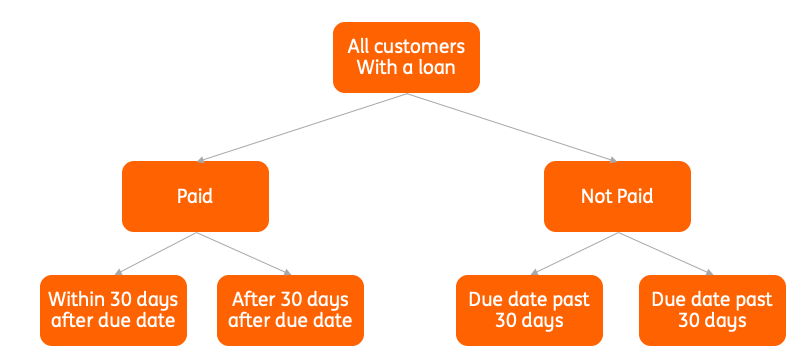

In [ ]:
# We will copy data from the original data frame because we don't want to overwrite the original df.
data = data_orj.copy()

In [ ]:
# To be able to calculates differences between dates we parse them into date format.
data['due_date'] = pd.to_datetime(data['due_date'], format='%Y-%m-%d')
data['paid_date'] = pd.to_datetime(data['paid_date'], format='%Y%m%d')

In [ ]:
# Boolean mask: If the customer paid or not
mask_paid = (~data['paid_date'].isna())

# Boolean mask: If customers paid after more than 30 days after due_date
mask_paid_date_30_days_past_due_date = (data['paid_date'] - data['due_date']).dt.days > 30
# Boolean mask: If more than 30 days past the due date
mask_current_date_30_days_past_due_date = (pd.to_datetime('2022-10-07') - data['due_date']).dt.days > 30

# LABEL 1: Paid but after 30 days after due date
data.loc[mask_paid & mask_paid_date_30_days_past_due_date, "label"] = 1

# LABEL 0: Paid within 30 days
data.loc[mask_paid & (~mask_paid_date_30_days_past_due_date), "label"] = 0

# LABEL 1: Not paid and 30 days past the due date
data.loc[(~mask_paid) & (mask_current_date_30_days_past_due_date), "label"] = 1

# Indeterminate: Not paid but still within 30 days period
data.loc[(~mask_paid) & (~mask_current_date_30_days_past_due_date), "label"] = -1

# Filter out indeterminate
data = data[data["label"] >= 0]


In [ ]:
data = data.drop(columns=['due_date', 'paid_date'])
data_with_label_orj = data.copy()

Postive Class Ratio 0.217


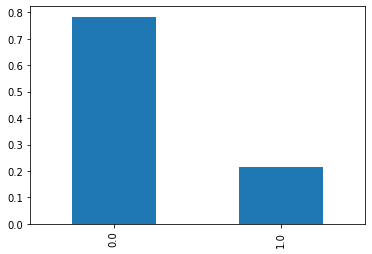

In [ ]:
class_ratio = data.label.value_counts(normalize=True)
class_ratio.plot(kind='bar')
print("Postive Class Ratio", class_ratio[1].round(3))

# Building the Baseline Model
Here in this part we will establish the baseline model and from there we will try to improve it.

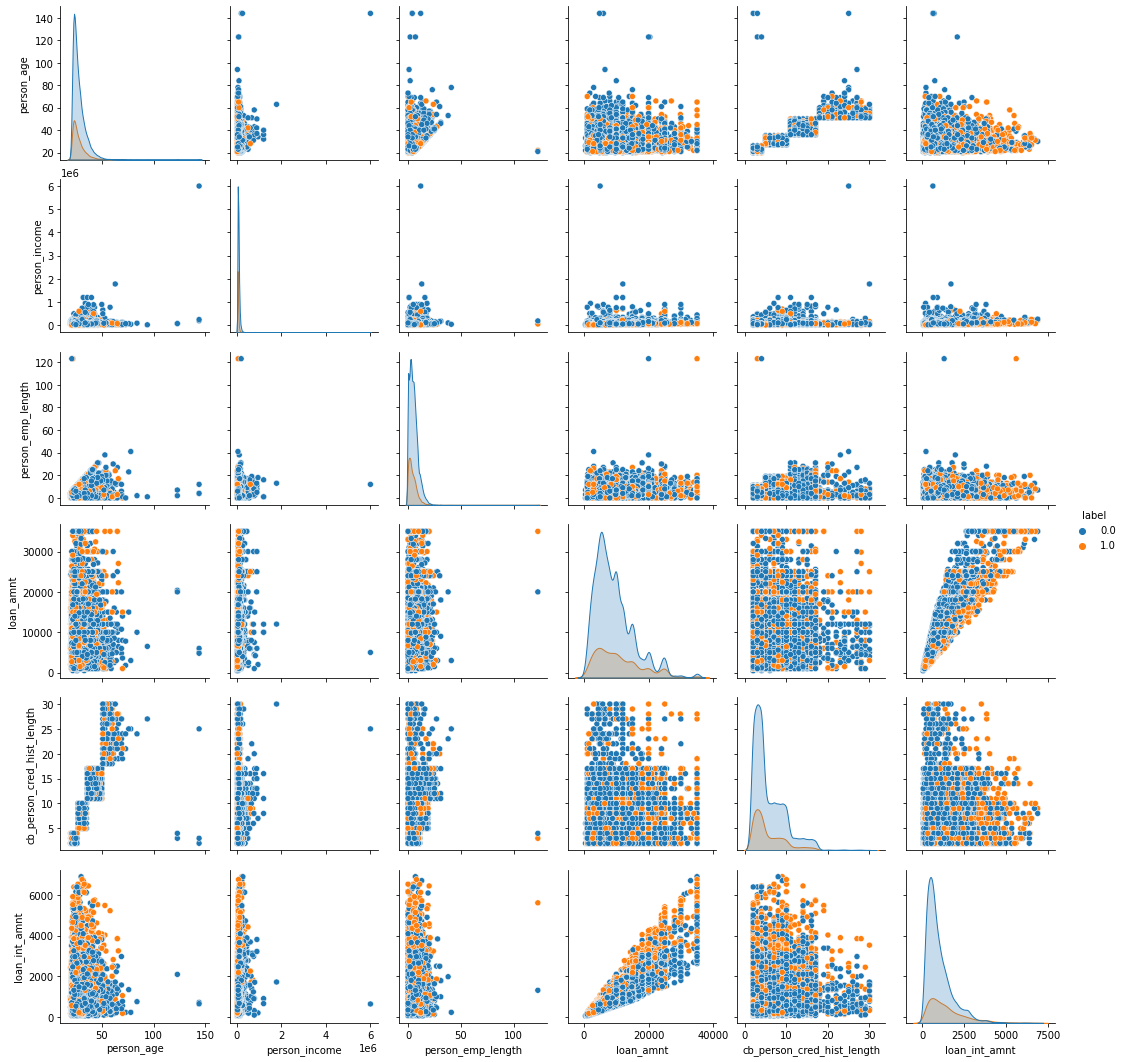

In [ ]:
sns.pairplot(data, hue='label')

In [ ]:
# Set data & x_test from originals because they might be modified in the previous sections
data = data_with_label_orj.copy()
x_test = x_test_orj.copy()
data.head(1)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,cb_person_default_on_file,cb_person_cred_hist_length,loan_int_amnt,label
0,25,60000,RENT,1.0,VENTURE,A,8400,N,2,612.36,0.0


In [ ]:
# We cannot feed models with categorical data, we need to create numerical representation for them
# In this section we will create binary representation for each value of a categorical feature.
data = pd.get_dummies(data, columns=["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"])
x_test = pd.get_dummies(x_test, columns=["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"])

data.head(1).T

,person_age,person_income,person_emp_length,loan_amnt,cb_person_cred_hist_length,loan_int_amnt,label,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,25,60000,1.0,8400,2,612.36,0.0,0,0,0,...,1,1,0,0,0,0,0,0,1,0


In [ ]:
# Drop NA for development data
print("Number of rows before NA removal:", data.shape[0])
data = data.dropna()
print("Number of rows after NA removal:", data.shape[0])

# Drop NA for test data
print("Number of rows before NA removal (test):", x_test.shape[0])
x_test = x_test.dropna()
print("Number of rows after NA removal (test):", x_test.shape[0])

Number of rows before NA removal: 24433
Number of rows after NA removal: 21495
Number of rows before NA removal (test): 8148
Number of rows after NA removal (test): 7143


In [ ]:
x = data.drop(columns='label')
y = data['label']

# Split the data into two subset, so we can use one subset to train the model 
# and other subset to test the model's performance
x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.33, random_state=32)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_train shape: (14401, 25)
y_train shape: (14401,)
x_val shape: (7094, 25)
y_val shape: (7094,)


In [ ]:
model = RandomForestClassifier(random_state=32)

In [ ]:
model.fit(x_train, y_train)

RandomForestClassifier(random_state=32)

In [ ]:
classification_results(y_val, model.predict_proba(x_val)[:,1], name="validation")

,roc_auc,accuracy,precision,recall,f1_score,tn_norm,fp_norm,fn_norm,tp_norm,tn,fp,fn,tp
validation,0.919,0.919,0.927,0.676,0.782,0.773,0.011,0.07,0.146,5486,81,494,1033


In [ ]:
# classification_results_test(y_pred_proba=model.predict_proba(x_test)[:,1])

In [ ]:
feat_imp = pd.Series(model.feature_importances_, index = x_train.columns.tolist()).sort_values(ascending=False)
feat_imp

person_income                     0.240689
loan_int_amnt                     0.135929
loan_amnt                         0.111220
loan_grade_D                      0.077607
person_emp_length                 0.068717
person_age                        0.057634
cb_person_cred_hist_length        0.046022
person_home_ownership_RENT        0.037051
loan_grade_E                      0.025597
loan_intent_DEBTCONSOLIDATION     0.023878
loan_intent_MEDICAL               0.022717
person_home_ownership_MORTGAGE    0.019061
loan_grade_C                      0.018646
loan_intent_HOMEIMPROVEMENT       0.016658
person_home_ownership_OWN         0.014972
loan_grade_A                      0.013636
loan_intent_EDUCATION             0.012299
loan_grade_B                      0.011849
loan_intent_PERSONAL              0.010173
loan_intent_VENTURE               0.009773
cb_person_default_on_file_N       0.008669
cb_person_default_on_file_Y       0.007886
loan_grade_F                      0.005533
loan_grade_

# Improving the Baseline Model
In this section we will slightly modify the initial model to make the model pipeline more flexible so you can experiment easily.

In [ ]:
# Set data & x_test from originals because they might be modified in the previous sections
data = data_with_label_orj.copy()
x_test = x_test_orj.copy()

x = data.drop(columns='label')
y = data['label']

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.33, random_state=32)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_train shape: (16370, 10)
y_train shape: (16370,)
x_val shape: (8063, 10)
y_val shape: (8063,)


In [ ]:
x_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,cb_person_default_on_file,cb_person_cred_hist_length,loan_int_amnt
14138,25,35000,RENT,1.0,MEDICAL,C,4800,N,2,493.44
14232,24,27000,RENT,3.0,VENTURE,A,8000,N,4,712.00
7435,25,75000,MORTGAGE,9.0,PERSONAL,C,10000,Y,2,1134.00
5446,24,65000,MORTGAGE,2.0,PERSONAL,B,8000,N,2,1015.20
21002,21,55000,MORTGAGE,5.0,EDUCATION,C,10000,N,2,1472.00


In [ ]:
model = RandomForestClassifier(random_state=32)

numeric_features = x_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = x_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', model)])



In [ ]:
model_pipeline.fit(x_train, y_train)
print("")

In [ ]:
classification_results(y_val, model_pipeline.predict_proba(x_val)[:,1], name="validation")

,roc_auc,accuracy,precision,recall,f1_score,tn_norm,fp_norm,fn_norm,tp_norm,tn,fp,fn,tp
validation,0.922,0.921,0.922,0.692,0.791,0.773,0.013,0.066,0.149,6229,101,534,1199


In [ ]:
classification_results_test(y_pred_proba=model_pipeline.predict_proba(x_test)[:,1], threshold=0.5)

,roc_auc,accuracy,precision,recall,f1_score,tn_norm,fp_norm,fn_norm,tp_norm,tn,fp,fn,tp,Cost
Test,0.925,0.927,0.944,0.714,0.813,0.768,0.009,0.064,0.159,6259,77,518,1294,259000


In [ ]:
classification_results_combined(y_train=y_train, 
                                y_train_pred_proba=model_pipeline.predict_proba(x_train)[:,1], 
                                y_val=y_val, 
                                y_val_pred_proba=model_pipeline.predict_proba(x_val)[:,1], 
                                y_test_pred_proba=model_pipeline.predict_proba(x_test)[:,1], 
                                threshold=0.5)

We expect to be less than 0.05! Otherwise, there is a high chance that your model won't perform as good as you expected.
Overfit AUC (Train-Val): 0.078
Overfit AUC (Train-Test): 0.075


,roc_auc,accuracy,precision,recall,f1_score,tn_norm,fp_norm,fn_norm,tp_norm,tn,fp,fn,tp,Cost
Train,1.000,1.000,1.000,1.000,1.000,0.782,0.000,0.000,0.218,12807,0,0,3563,NaN
Validation,0.922,0.921,0.922,0.692,0.791,0.773,0.013,0.066,0.149,6229,101,534,1199,NaN
Test,0.925,0.927,0.944,0.714,0.813,0.768,0.009,0.064,0.159,6259,77,518,1294,259000.0


## Outlier Handling
In this section you can try to identify outlier values in your features, and treat them to prevent them to mislead your model.

In [ ]:
stats = x_train.describe().T
stats['IQR'] = stats['75%'] - stats['25%']
stats['lower_threshold'] = stats['25%'] - stats['IQR'] * 1.5
stats['upper_threshold'] = stats['75%'] + stats['IQR'] * 1.5

feat_imp_order = [feat for feat in feat_imp.index if feat in stats.index]
stats.loc[feat_imp_order].loc[stats['max']>1]

,count,mean,std,min,25%,50%,75%,max,IQR,lower_threshold,upper_threshold
person_income,16370.0,66045.346426,52081.218584,4000.0,38400.00,55000.0,79631.75,1782000.0,41231.75,-23447.625,141479.375
loan_int_amnt,14835.0,1084.874604,884.660989,48.8,476.35,810.7,1411.00,6891.5,934.65,-925.625,2812.975
loan_amnt,16370.0,9571.763897,6342.737428,500.0,5000.00,8000.0,12000.00,35000.0,7000.00,-5500.000,22500.000
person_emp_length,15908.0,4.793186,4.124848,0.0,2.00,4.0,7.00,123.0,5.00,-5.500,14.500
person_age,16370.0,27.746121,6.316141,20.0,23.00,26.0,30.00,144.0,7.00,12.500,40.500
cb_person_cred_hist_length,16370.0,5.797984,4.019630,2.0,3.00,4.0,8.00,30.0,5.00,-4.500,15.500


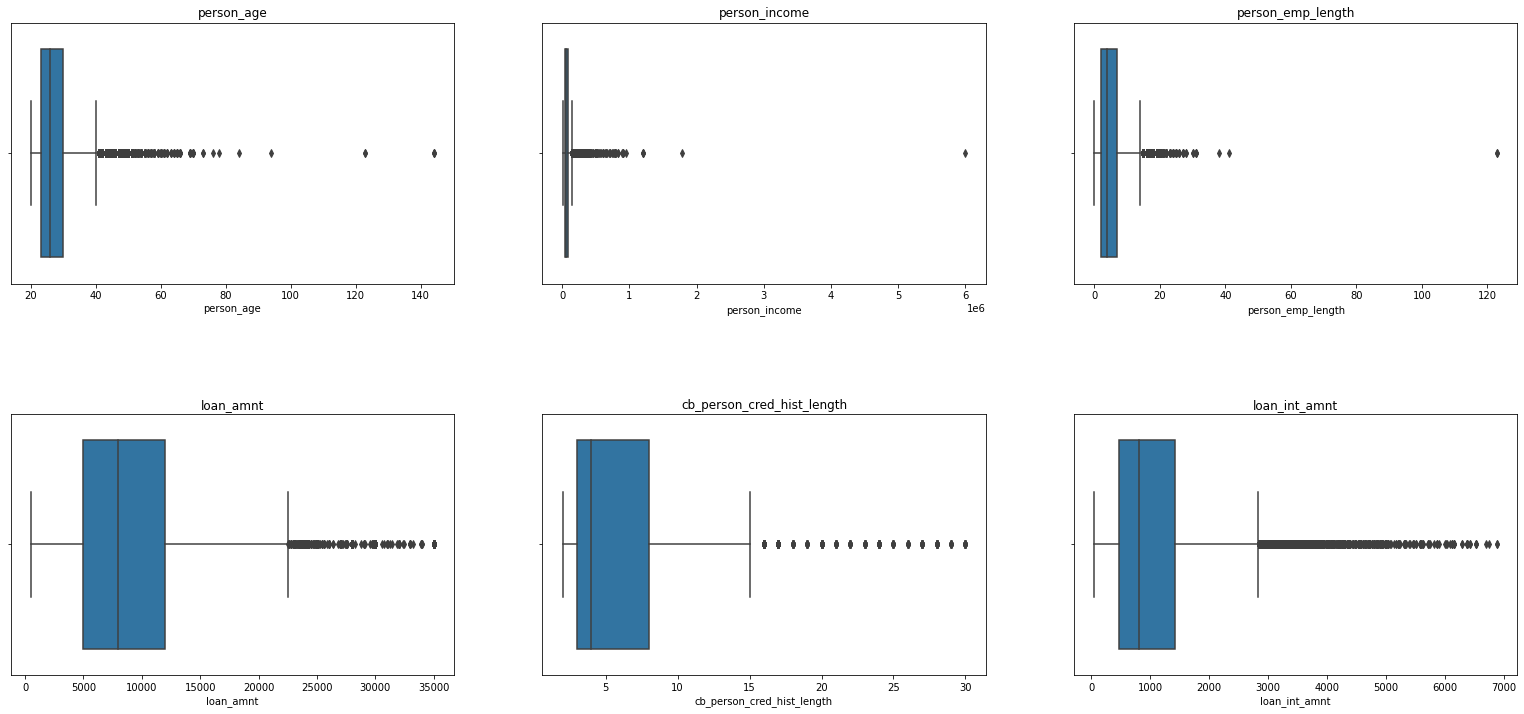

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(9*3, 4*3))
fig.subplots_adjust(hspace=0.5)
axes = (ax for ax in axes.flat)
for col in data.select_dtypes(include=['int64', 'float64']).columns:
    if data[col].nunique()==2: continue
    ax_ = sns.boxplot(data=data, x=col, ax=next(axes))
    ax_.set_title(col)
plt.show()

In [ ]:
# TODO: Delete in student version

x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.33, random_state=32)


# Cap person_age above 85
# Cap person_income above 140000
# Cap person_emp_length above 20

x_train['person_age'] = x_train['person_age'].mask(x_train['person_age'] >= 85, 85)
x_train['person_income'] = x_train['person_income'].mask(x_train['person_income'] >= 140000, 140000)
x_train['person_emp_length'] = x_train['person_emp_length'].mask(x_train['person_emp_length'] >= 20, 20)

In [ ]:
# TODO: Delete in student version

model_pipeline.fit(x_train, y_train)
print("")

In [ ]:
# TODO: Delete in student version

classification_results_combined(y_train=y_train, 
                                y_train_pred_proba=model_pipeline.predict_proba(x_train)[:,1], 
                                y_val=y_val, 
                                y_val_pred_proba=model_pipeline.predict_proba(x_val)[:,1], 
                                y_test_pred_proba=model_pipeline.predict_proba(x_test)[:,1], 
                                threshold=0.5)

We expect to be less than 0.05! Otherwise, there is a high chance that your model won't perform as good as you expected.
Overfit AUC (Train-Val): 0.079
Overfit AUC (Train-Test): 0.076


,roc_auc,accuracy,precision,recall,f1_score,tn_norm,fp_norm,fn_norm,tp_norm,tn,fp,fn,tp,Cost
Train,1.000,1.000,1.000,1.000,1.000,0.782,0.000,0.000,0.218,12807,0,0,3563,NaN
Validation,0.921,0.923,0.927,0.697,0.796,0.773,0.012,0.065,0.150,6235,95,525,1208,NaN
Test,0.924,0.927,0.941,0.719,0.815,0.768,0.010,0.063,0.160,6254,82,510,1302,255000.0


## Feature Engineering
In this section, you can develop new features and test them if they improve your model's performance.

In [ ]:
# Set data & x_test from originals because they might be modified in the previous sections
data = data_with_label_orj.copy()
x_test = x_test_orj.copy()

In [ ]:
# Create your features here for both data and x_test dataframe.

In [ ]:
# TODO: Delete in student version

data['loan_int_rate'] = data['loan_int_amnt'] / data['loan_amnt']
data['loan_to_income_ratio'] = data['loan_amnt'] / data['person_income']

x_test['loan_int_rate'] = x_test['loan_int_amnt'] / x_test['loan_amnt']
x_test['loan_to_income_ratio'] = x_test['loan_amnt'] / x_test['person_income']


In [ ]:
x = data.drop(columns='label')
y = data['label']

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.33, random_state=32)

In [ ]:
model_pipeline.fit(x_train, y_train)
print("")

In [ ]:
classification_results_combined(y_train=y_train, 
                                y_train_pred_proba=model_pipeline.predict_proba(x_train)[:,1], 
                                y_val=y_val, 
                                y_val_pred_proba=model_pipeline.predict_proba(x_val)[:,1], 
                                y_test_pred_proba=model_pipeline.predict_proba(x_test)[:,1], 
                                threshold=0.5)

We expect to be less than 0.05! Otherwise, there is a high chance that your model won't perform as good as you expected.
Overfit AUC (Train-Val): 0.078
Overfit AUC (Train-Test): 0.075


,roc_auc,accuracy,precision,recall,f1_score,tn_norm,fp_norm,fn_norm,tp_norm,tn,fp,fn,tp,Cost
Train,1.000,1.000,1.000,1.000,1.000,0.782,0.000,0.000,0.218,12807,0,0,3563,NaN
Validation,0.922,0.921,0.922,0.692,0.791,0.773,0.013,0.066,0.149,6229,101,534,1199,NaN
Test,0.925,0.927,0.944,0.714,0.813,0.768,0.009,0.064,0.159,6259,77,518,1294,259000.0


## Correlated Feature Removal

In [ ]:
# Set data & x_test from originals because they might be modified in the previous sections
data = data_with_label_orj.copy()
x_test = x_test_orj.copy()

x = data.drop(columns='label')
y = data['label']

x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.33, random_state=32)

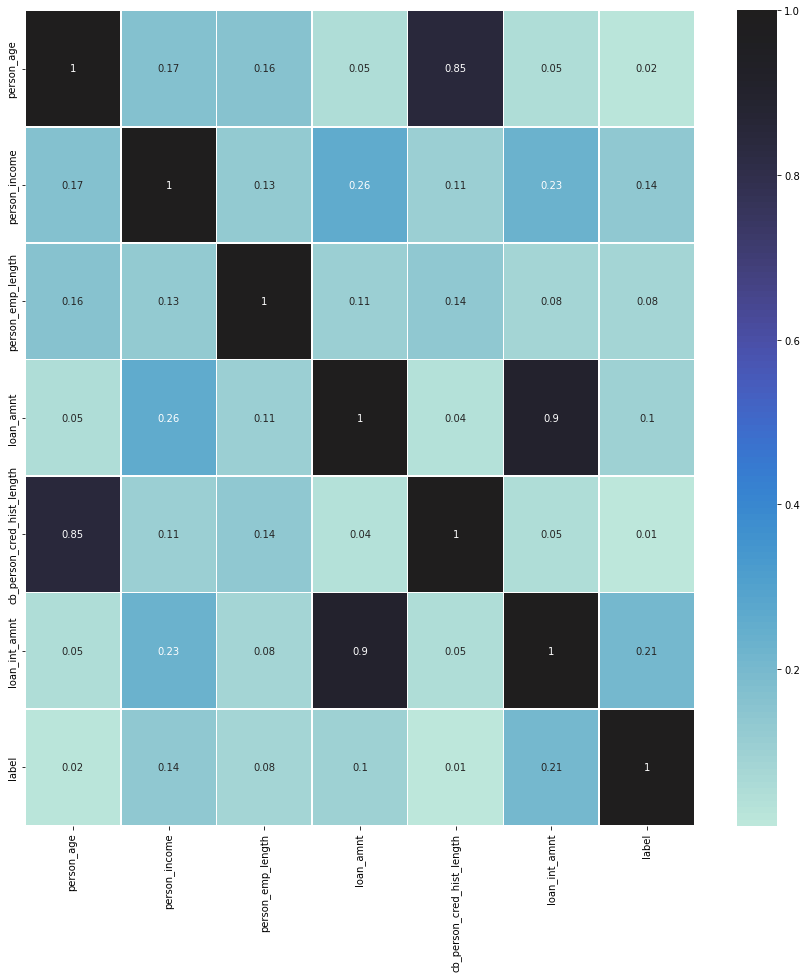

In [ ]:
col_order = data.columns.tolist()
# to move label rightmost side, first remove from the list 
# and add it back to at the end of the list
col_order.remove('label')
col_order.append('label')

correlations = data[col_order].corr().abs().round(2)
f, ax = plt.subplots(figsize = (15,15))
sns.heatmap(correlations, annot=True,linewidths=.5, center=1)

In [ ]:
# List the columns that you want to drop
columns_to_drop = []

In [ ]:
# TODO: Delete in student version
columns_to_drop = ["loan_amnt", "cb_person_cred_hist_length"]

In [ ]:
data = data.drop(columns=columns_to_drop)
x_test = x_test.drop(columns=columns_to_drop)

In [ ]:
x = data.drop(columns='label')
y = data['label']

x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.33, random_state=32)

In [ ]:
model = RandomForestClassifier(random_state=32)

numeric_features = x_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = x_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', model)])



In [ ]:
model_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['person_age', 'person_income', 'person_emp_length', 'loan_int_amnt'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['person_home_o

In [ ]:
classification_results_combined(y_train=y_train, 
                                y_train_pred_proba=model_pipeline.predict_proba(x_train)[:,1], 
                                y_val=y_val, 
                                y_val_pred_proba=model_pipeline.predict_proba(x_val)[:,1], 
                                y_test_pred_proba=model_pipeline.predict_proba(x_test)[:,1], 
                                threshold=0.5)

We expect to be less than 0.05! Otherwise, there is a high chance that your model won't perform as good as you expected.
Overfit AUC (Train-Val): 0.087
Overfit AUC (Train-Test): 0.085


,roc_auc,accuracy,precision,recall,f1_score,tn_norm,fp_norm,fn_norm,tp_norm,tn,fp,fn,tp,Cost
Train,1.000,1.000,1.000,1.000,1.000,0.782,0.000,0.000,0.218,12807,0,0,3563,NaN
Validation,0.913,0.909,0.890,0.656,0.755,0.768,0.017,0.074,0.141,6190,140,596,1137,NaN
Test,0.915,0.911,0.901,0.675,0.772,0.761,0.016,0.072,0.150,6202,134,588,1224,294000.0


## Handling Missing Data

In [ ]:
# Set data & x_test from originals because they might be modified in the previous sections
data = data_with_label_orj.copy()
x_test = x_test_orj.copy()

x = data.drop(columns='label')
y = data['label']

x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.33, random_state=32)

In [ ]:

model = RandomForestClassifier(random_state=32)

numeric_features = x_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = x_train.select_dtypes(include=['object']).columns

# You can modify the numeric_transformer below to change how you handle missing values in numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ])
# You can modify the categorical_transformer below to change how you handle missing values in categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', model)])



In [ ]:
# TODO: Delete in student version

model = RandomForestClassifier(random_state=32)

numeric_features = x_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = x_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', model)])



In [ ]:
model_pipeline.fit(x_train, y_train)
print("model fitted")

model fitted


In [ ]:
classification_results_combined(y_train=y_train, 
                                y_train_pred_proba=model_pipeline.predict_proba(x_train)[:,1], 
                                y_val=y_val, 
                                y_val_pred_proba=model_pipeline.predict_proba(x_val)[:,1], 
                                y_test_pred_proba=model_pipeline.predict_proba(x_test)[:,1], 
                                threshold=0.5)

We expect to be less than 0.05! Otherwise, there is a high chance that your model won't perform as good as you expected.
Overfit AUC (Train-Val): 0.078
Overfit AUC (Train-Test): 0.072


,roc_auc,accuracy,precision,recall,f1_score,tn_norm,fp_norm,fn_norm,tp_norm,tn,fp,fn,tp,Cost
Train,1.000,1.000,1.000,1.000,1.000,0.782,0.000,0.000,0.218,12807,0,0,3563,NaN
Validation,0.922,0.922,0.921,0.698,0.794,0.772,0.013,0.065,0.150,6226,104,524,1209,NaN
Test,0.928,0.926,0.936,0.719,0.813,0.767,0.011,0.063,0.160,6247,89,510,1302,255000.0


## Preprocessing

### OrdinalEncoder 

In [ ]:
# Set data & x_test from originals because they might be modified in the previous sections
data = data_with_label_orj.copy()
x_test = x_test_orj.copy()

x = data.drop(columns='label')
y = data['label']

x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.33, random_state=32)

In [ ]:
train_data = pd.concat([x_train, y_train], axis=1)
display(train_data.groupby(['person_home_ownership'])['label'].mean().sort_values())
display(train_data.groupby(['loan_grade'])['label'].mean().sort_values())

person_home_ownership
OWN         0.076687
MORTGAGE    0.126727
OTHER       0.288136
RENT        0.313316
Name: label, dtype: float64

loan_grade
A    0.097340
B    0.160955
C    0.211416
D    0.594505
E    0.632696
F    0.677686
G    0.974359
Name: label, dtype: float64

In [ ]:
# TODO: Delete in student version
person_home_ownership_order = train_data.groupby(['person_home_ownership'])['label'].mean().sort_values().index.tolist()
loan_grade_order = train_data.groupby(['loan_grade'])['label'].mean().sort_values().index.tolist()

In [ ]:
# Modify the pipeline below to implement ordinal encoder for some of the categorical features
model = RandomForestClassifier(random_state=32)

numeric_features = x_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = x_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', model)])



In [ ]:
# TODO: Delete in student version
model = RandomForestClassifier(random_state=32)

numeric_features = x_train.select_dtypes(include=['int64', 'float64']).columns
ordinal_features = ['person_home_ownership', 'loan_grade']
categorical_features = list(set(x_train.select_dtypes(include=['object']).columns) - set(ordinal_features))

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder(categories=[person_home_ownership_order, loan_grade_order]))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)
        ])

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', model)])



In [ ]:
model_pipeline.fit(x_train, y_train)
print("model fitted")

model fitted


In [ ]:
classification_results_combined(y_train=y_train, 
                                y_train_pred_proba=model_pipeline.predict_proba(x_train)[:,1], 
                                y_val=y_val, 
                                y_val_pred_proba=model_pipeline.predict_proba(x_val)[:,1], 
                                y_test_pred_proba=model_pipeline.predict_proba(x_test)[:,1], 
                                threshold=0.5)

We expect to be less than 0.05! Otherwise, there is a high chance that your model won't perform as good as you expected.
Overfit AUC (Train-Val): 0.076
Overfit AUC (Train-Test): 0.073


,roc_auc,accuracy,precision,recall,f1_score,tn_norm,fp_norm,fn_norm,tp_norm,tn,fp,fn,tp,Cost
Train,1.000,1.000,1.000,1.000,1.00,0.782,0.000,0.000,0.218,12807,0,0,3563,NaN
Validation,0.924,0.925,0.934,0.699,0.80,0.775,0.011,0.065,0.150,6245,85,522,1211,NaN
Test,0.927,0.930,0.954,0.719,0.82,0.770,0.008,0.062,0.160,6273,63,509,1303,254500.0


## Hyper-parameter Optimisation

In [ ]:
# Set data & x_test from originals because they might be modified in the previous sections
data = data_with_label_orj.copy()
x_test = x_test_orj.copy()

x = data.drop(columns='label')
y = data['label']

x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.33, random_state=32)

In [ ]:
model = RandomForestClassifier(random_state=32)

train_data = pd.concat([x_train, y_train], axis=1)
person_home_ownership_order = train_data.groupby(['person_home_ownership'])['label'].mean().sort_values().index.tolist()
loan_grade_order = train_data.groupby(['loan_grade'])['label'].mean().sort_values().index.tolist()

numeric_features = x_train.select_dtypes(include=['int64', 'float64']).columns
ordinal_features = ['person_home_ownership', 'loan_grade']
categorical_features = list(set(x_train.select_dtypes(include=['object']).columns) - set(ordinal_features))

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder(categories=[person_home_ownership_order, loan_grade_order]))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)
        ])

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', model)])

In [ ]:
# Add hyper-paramter tuning code here

In [ ]:
# TODO: Delete in student version

param_grid = { 
    'classifier__n_estimators': [100, 200, 400, 1000],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__max_depth' : [5, 10, 20, 40, 50, None],
    'classifier__criterion' :['gini', 'entropy']
}



model_pipeline = RandomizedSearchCV(model_pipeline, 
                    param_distributions = param_grid,
                    n_iter=50,
                    cv = 3,  
                    scoring = 'roc_auc', 
                    verbose = 100, 
                    n_jobs = 1, 
                    random_state=32
                    )

In [ ]:
model_pipeline.fit(x_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3; 1/50] START classifier__criterion=entropy, classifier__max_depth=50, classifier__max_features=auto, classifier__min_samples_split=5, classifier__n_estimators=400
[CV 1/3; 1/50] END classifier__criterion=entropy, classifier__max_depth=50, classifier__max_features=auto, classifier__min_samples_split=5, classifier__n_estimators=400;, score=0.921 total time=   7.8s
[CV 2/3; 1/50] START classifier__criterion=entropy, classifier__max_depth=50, classifier__max_features=auto, classifier__min_samples_split=5, classifier__n_estimators=400
[CV 2/3; 1/50] END classifier__criterion=entropy, classifier__max_depth=50, classifier__max_features=auto, classifier__min_samples_split=5, classifier__n_estimators=400;, score=0.927 total time=   7.7s
[CV 3/3; 1/50] START classifier__criterion=entropy, classifier__max_depth=50, classifier__max_features=auto, classifier__min_samples_split=5, classifier__n_estimators=400
[CV 3/3; 1/50] END cl

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median'))]),
                                                                               Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'cb_person_cred_hist_length', 'loan_int_amnt'],
      dtype='object')),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fil...
                                              R

In [ ]:
classification_results_combined(y_train=y_train, 
                                y_train_pred_proba=model_pipeline.predict_proba(x_train)[:,1], 
                                y_val=y_val, 
                                y_val_pred_proba=model_pipeline.predict_proba(x_val)[:,1], 
                                y_test_pred_proba=model_pipeline.predict_proba(x_test)[:,1], 
                                threshold=0.5)

We expect to be less than 0.05! Otherwise, there is a high chance that your model won't perform as good as you expected.
Overfit AUC (Train-Val): 0.07
Overfit AUC (Train-Test): 0.069


,roc_auc,accuracy,precision,recall,f1_score,tn_norm,fp_norm,fn_norm,tp_norm,tn,fp,fn,tp,Cost
Train,1.000,0.983,1.000,0.923,0.960,0.782,0.000,0.017,0.201,12807,0,274,3289,NaN
Validation,0.930,0.925,0.936,0.698,0.799,0.775,0.010,0.065,0.150,6247,83,524,1209,NaN
Test,0.931,0.929,0.955,0.714,0.817,0.770,0.007,0.064,0.159,6275,61,518,1294,259000.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,roc_auc,accuracy,precision,recall,f1_score,tn_norm,fp_norm,fn_norm,tp_norm,tn,fp,fn,tp,Cost
0.250,0.931,0.892,0.734,0.809,0.770,0.712,0.065,0.042,0.180,5804,532,346,1466,173000
0.375,0.931,0.923,0.875,0.762,0.815,0.753,0.024,0.053,0.169,6139,197,431,1381,215500
0.500,0.931,0.929,0.955,0.714,0.817,0.770,0.007,0.064,0.159,6275,61,518,1294,259000
0.625,0.931,0.921,0.981,0.656,0.786,0.775,0.003,0.077,0.146,6313,23,624,1188,312000
0.125,0.931,0.768,0.488,0.897,0.632,0.568,0.209,0.023,0.199,4631,1705,187,1625,327500
0.750,0.931,0.908,0.993,0.589,0.740,0.777,0.001,0.091,0.131,6328,8,744,1068,372000
0.875,0.931,0.863,1.000,0.386,0.557,0.778,0.000,0.137,0.086,6336,0,1113,699,556500
0.000,0.931,0.224,0.223,1.000,0.364,0.001,0.776,0.000,0.222,11,6325,0,1812,1066000
1.000,0.931,0.778,0.000,0.000,0.000,0.778,0.000,0.222,0.000,6336,0,1812,0,1406000


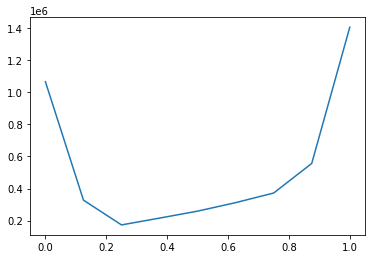

In [ ]:
# TODO: Delete in student version

threshold_results = pd.concat([classification_results_test(y_pred_proba=model_pipeline.predict_proba(x_test)[:,1], 
                                threshold=threshold, 
                                name=threshold)
            for threshold in np.linspace(0, 1, 9)
            ])
display(threshold_results.sort_values("Cost"))
threshold_results["Cost"].plot()
print("")

## Model Selection

In [ ]:
# Set data & x_test from originals because they might be modified in the previous sections
data = data_with_label_orj.copy()
x_test = x_test_orj.copy()

data['loan_int_rate'] = data['loan_int_amnt'] / data['loan_amnt']
data['loan_to_income_ratio'] = data['loan_amnt'] / data['person_income']

x_test['loan_int_rate'] = x_test['loan_int_amnt'] / x_test['loan_amnt']
x_test['loan_to_income_ratio'] = x_test['loan_amnt'] / x_test['person_income']

columns_to_drop = ["loan_amnt", "cb_person_cred_hist_length"]
data = data.drop(columns=columns_to_drop)
x_test = x_test.drop(columns=columns_to_drop)

x = data.drop(columns='label')
y = data['label']

x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.33, random_state=32)

In [ ]:
# Implement a model pipeline that use models other than RandomForestClassifier

# You can change model type below
model = RandomForestClassifier(random_state=32)

# You can also modify the rest of the pipeline to incorporate other improvements
numeric_features = x_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = x_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', model)])



In [ ]:
# TODO: Delete in student version

model = LGBMClassifier(random_state=32)

train_data = pd.concat([x_train, y_train], axis=1)
person_home_ownership_order = train_data.groupby(['person_home_ownership'])['label'].mean().sort_values().index.tolist()
loan_grade_order = train_data.groupby(['loan_grade'])['label'].mean().sort_values().index.tolist()

numeric_features = x_train.select_dtypes(include=['int64', 'float64']).columns
ordinal_features = ['person_home_ownership', 'loan_grade']
categorical_features = list(set(x_train.select_dtypes(include=['object']).columns) - set(ordinal_features))

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder(categories=[person_home_ownership_order, loan_grade_order]))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)
        ])

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', model)])

In [ ]:
model_pipeline.fit(x_train, y_train)
print("")

In [ ]:
classification_results_combined(y_train=y_train, 
                                y_train_pred_proba=model_pipeline.predict_proba(x_train)[:,1], 
                                y_val=y_val, 
                                y_val_pred_proba=model_pipeline.predict_proba(x_val)[:,1], 
                                y_test_pred_proba=model_pipeline.predict_proba(x_test)[:,1], 
                                threshold=0.5)

Overfit AUC (Train-Val): 0.038
Overfit AUC (Train-Test): 0.036


,roc_auc,accuracy,precision,recall,f1_score,tn_norm,fp_norm,fn_norm,tp_norm,tn,fp,fn,tp,Cost
Train,0.982,0.946,0.989,0.760,0.860,0.781,0.002,0.052,0.165,12778,29,856,2707,NaN
Validation,0.944,0.933,0.958,0.718,0.821,0.778,0.007,0.061,0.154,6276,54,488,1245,NaN
Test,0.946,0.937,0.967,0.742,0.839,0.772,0.006,0.057,0.165,6290,46,468,1344,234000.0


# Optimising the model based on capacity and cost
Your success depends not purely on model performance but also on how you finetune it based on your business case.
In this section, you can calibrate your threshold based on the information given in the section.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,roc_auc,accuracy,precision,recall,f1_score,tn_norm,fp_norm,fn_norm,tp_norm,tn,fp,fn,tp,Cost
0.250,0.946,0.920,0.839,0.791,0.814,0.744,0.034,0.047,0.176,6061,275,379,1433,189500
0.125,0.946,0.851,0.616,0.879,0.724,0.656,0.122,0.027,0.195,5342,994,220,1592,214000
0.375,0.946,0.934,0.927,0.762,0.836,0.764,0.013,0.053,0.169,6227,109,432,1380,216000
0.500,0.946,0.937,0.967,0.742,0.839,0.772,0.006,0.057,0.165,6290,46,468,1344,234000
0.625,0.946,0.937,0.985,0.726,0.836,0.775,0.002,0.061,0.161,6316,20,497,1315,248500
0.750,0.946,0.934,0.993,0.710,0.828,0.777,0.001,0.065,0.158,6327,9,526,1286,263000
0.875,0.946,0.930,1.000,0.685,0.813,0.778,0.000,0.070,0.152,6336,0,570,1242,285000
0.000,0.946,0.222,0.222,1.000,0.364,0.000,0.778,0.000,0.222,0,6336,0,1812,1066000
1.000,0.946,0.778,0.000,0.000,0.000,0.778,0.000,0.222,0.000,6336,0,1812,0,1406000


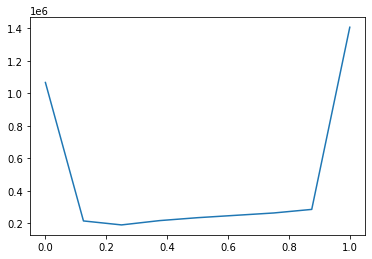

In [ ]:
# TODO: Delete in student version

threshold_results = pd.concat([classification_results_test(y_pred_proba=model_pipeline.predict_proba(x_test)[:,1], 
                                threshold=threshold, 
                                name=threshold)
            for threshold in np.linspace(0, 1, 9)
            ])
display(threshold_results.sort_values("Cost"))
threshold_results["Cost"].plot()

# Eliminating Overfit
In practice we don't want a high overfit because that often leads to unreliable results in production. In this section you can try to find a way to eliminate it.

In [ ]:
cv_results = pd.DataFrame(model_pipeline.cv_results_)

cv_results_dict = []
for index, row in cv_results.iterrows():
    model_pipeline.set_params(**row.params)
    model_pipeline.fit(x_train, y_train)
    result = classification_results_combined(y_train=y_train, 
                                y_train_pred_proba=model_pipeline.predict_proba(x_train)[:,1], 
                                y_val=y_val, 
                                y_val_pred_proba=model_pipeline.predict_proba(x_val)[:,1], 
                                y_test_pred_proba=model_pipeline.predict_proba(x_test)[:,1], 
                                threshold=0.5, print_overfit=False)
    test_auc = result.loc['Test', 'roc_auc']
    train_auc = result.loc['Train', 'roc_auc']
    overfit = train_auc - test_auc
    param_result = {
        "test_auc": test_auc,
        "overfit": overfit,
        "params": row.params
    }
    cv_results_dict.append(param_result)
    print(param_result)
    

{'test_auc': 0.948, 'overfit': 0.052000000000000046, 'params': {'classifier__n_estimators': 400, 'classifier__min_samples_split': 5, 'classifier__max_features': 'auto', 'classifier__max_depth': 50, 'classifier__criterion': 'entropy'}}
{'test_auc': 0.948, 'overfit': 0.04700000000000004, 'params': {'classifier__n_estimators': 200, 'classifier__min_samples_split': 10, 'classifier__max_features': 'sqrt', 'classifier__max_depth': None, 'classifier__criterion': 'gini'}}
{'test_auc': 0.948, 'overfit': 0.04700000000000004, 'params': {'classifier__n_estimators': 200, 'classifier__min_samples_split': 5, 'classifier__max_features': 'sqrt', 'classifier__max_depth': None, 'classifier__criterion': 'entropy'}}
{'test_auc': 0.948, 'overfit': 0.04700000000000004, 'params': {'classifier__n_estimators': 200, 'classifier__min_samples_split': 5, 'classifier__max_features': 'log2', 'classifier__max_depth': 40, 'classifier__criterion': 'gini'}}
{'test_auc': 0.948, 'overfit': 0.04700000000000004, 'params': {'

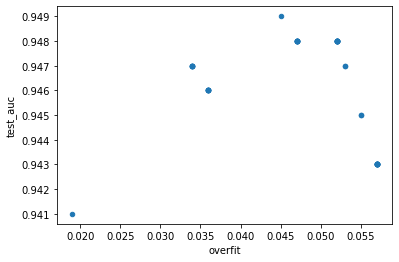

In [ ]:
pd.DataFrame(cv_results_dict).plot.scatter(x='overfit', y='test_auc')